In [15]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from scipy import stats
import math
from typing import List, Tuple, Any
import sqlite3
import os
import pandas as pd

In [61]:
def plot_tests_vs(tests_acromym, value, prefix="", focus_dict = None, table_name="results"):
    """
    Creates the image of a grid of the global/local transformation between dstributions
    """
    plt.figure(figsize=(10,6))

    #creating the grid for the plot
    size = len(tests_acromym)
    grid = np.zeros((size, size))

    for i, global_name in enumerate(tests_acromym):
        for j, local_name in enumerate(tests_acromym):
            database_path = os.path.join("Databases", f"database_{prefix}{global_name}2{local_name}.db")

            try:
                # Use context manager for database connection
                with sqlite3.connect(database_path) as conn:
                    
                    if focus_dict is None: # If focus = None then we consider all the available values
                        cursor = conn.cursor()

                        # Fetching all the values from the table
                        query = f"SELECT {value} FROM {table_name}"
                        cursor.execute(query)
                    
                        results = cursor.fetchall()

                        # Convert results to numpy arrays
                        x_list = []
                        for row in results:
                            if (row[0] is not None):
                                x_list.append(float(row[0]))
                            else:
                                print("one None found")
                        x_array = np.array(x_list)

                    else:
                        df = pd.read_sql("table_name", conn)
                        mask = pd.Series(True, index=df.index)
                        
                        for column, values in focus_dict.items():
                            mask &= df[column].isin(values)
                        
                        # Obtaining all the values that follow the focus requirement
                        values_list = df[mask]['value'].tolist()

                        x_list = []
                        for x in values_list:
                            if x is not None:
                                x_list.append(x)
                            else:
                                print("one None found")

                        # Converting into the numpy array
                        x_array = np.array(x_list)

                grid[i][j] = np.average(x_array)

            except sqlite3.Error as e:
                print(f"Database error: {e}")
            except Exception as e:
                print(f"Error: {e}")

    # Plot the grid with proper configuration
    plt.figure(figsize=(10, 6))
    im = plt.imshow(grid, cmap='viridis', aspect='equal')
    
    # Add colorbar
    plt.colorbar(im, label=value)
    
    # Add labels and ticks
    plt.xticks(range(size), tests_acromym, rotation=45)
    plt.yticks(range(size), tests_acromym)
    
    # Add labels for axes
    plt.xlabel('Local Distribution')
    plt.ylabel('Global Distribution')
    
    # Add title
    plt.title(f'Local Trasformation - {value}')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    print(grid)
                
            



def plot_database_columns(test_names, x_column, y_column, table_name="results", z_column=None, focus=None):
    """
    Create a scatter plot from two columns in a SQLite database table.
    
    Parameters:
    test_names (list): List of names of the tests to be plotted
    x_column (str): Name of the column to plot on x-axis
    y_column (str): Name of the column to plot on y-axis
    table_name (str): Name of the table in the database
    z_column (str, optional): Name of column to filter on
    focus (list, optional): List of values to filter z_column by
    """

    # Create figure once, outside the loop
    plt.figure(figsize=(8, 4))
    # Create a list of colors for different tests
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    # Store statistics for all tests
    stats_summary = {}

    for idx, test_name in enumerate(test_names):

        # Select the right database and color for the plotting
        color = colors[idx % len(colors)]  # Cycle through colors if more tests than colors
        database_path = os.path.join("Databases", f"database_{test_name}.db")

        try:
            # Use context manager for database connection
            with sqlite3.connect(database_path) as conn:
                cursor = conn.cursor()
                
                # Create a query to select the desired columns with optional filtering
                if z_column and focus:
                    # Convert the focus list to string for SQL IN clause
                    focus_str = ', '.join('?' * len(focus))
                    # No need for separate column selection if column_z is x_column or y_column
                    query = f"""
                        SELECT DISTINCT {x_column}, {y_column}
                        FROM {table_name}
                        WHERE {z_column} IN ({focus_str})
                    """
                    # Execute with parameters
                    cursor.execute(query, focus)
                else:
                    query = f"SELECT {x_column}, {y_column} FROM {table_name}"
                    cursor.execute(query)
                
                results = cursor.fetchall()
                
                if not results:
                    print("No data found matching the specified criteria.")
                    return
            
            # Convert results directly to numpy arrays
            #x_array = np.array([float(row[0]) for row in results])
            #y_array = np.array([float(row[1]) for row in results])

            # Convert results to numpy arrays
            x_list = []
            y_list = []
            for row in results:
                if (row[0] is not None) and (row[1] is not None):
                    x_list.append(float(row[0]))
                    y_list.append(float(row[1]))
                else:
                    print("one None found")
            x_array = np.array(x_list)
            y_array = np.array(y_list)
            
            # Calculate regression line
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
            
            # Create points for regression line
            line_x = np.array([x_array.min(), x_array.max()]).reshape(-1, 1)
            line_y = slope * line_x + intercept

            # Store statistics
            stats_summary[test_name] = {
                'slope': slope,
                'intercept': intercept,
                'r_squared': r_value**2,
                'p_value': p_value,
                'std_err': std_err
            }
            #print(f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')
            
            # Create the scatter plot
            plt.scatter(x_array, y_array, alpha=0.3, color=color, s=5)
            
            # Plot regression line
            plt.plot(line_x, line_y, linestyle='-', label=f"{test_name}", color=color)
                    #label=f'Regression line\ny = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.4f}\np value = {p_value}\nstd_error = {std_err}')            
            
        except sqlite3.Error as e:
            print(f"Database error: {e}")
        except Exception as e:
            print(f"Error: {e}")

   # Customize the plot (only once, after all tests are plotted)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    title = f'{y_column} vs {x_column}'
    if z_column and focus:
        title += f'\n(filtered {z_column} in {focus})'
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Print detailed statistics
    print("\nRegression Statistics:")
    print("-" * 50)
    for test_name, stats_dict in stats_summary.items():
        print(f"\n{test_name}:")
        print(f"Equation: y = {stats_dict['slope']:.4f}x + {stats_dict['intercept']:.4f}")
        print(f"R² = {stats_dict['r_squared']:.4f}")
        print(f"p-value = {stats_dict['p_value']:.4e}")
        print(f"Standard Error = {stats_dict['std_err']:.4f}")

    # Show the plot (only once, after everything is done)
    plt.show()

one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found
one None found

Regression Statistics:
--------------------------------------------------

M2B:
Equation: y = -0.0859x + 0.6209
R² = 0.1303
p-value = 1.2404e-04
Standard Error = 0.0216

B2B:
Equation: y = -0.0252x + 0.4867
R² = 0.1668
p-value = 1.1432e-05
Standard Error = 0.0055

G2B:
Equation: y = -0.0437x + 0.4085
R² = 0.0995
p-value = 1.3130e-03
Standard Error = 0.0132

S2B:
Equation: y = -0.1478x + 0.7512
R² = 0.0796
p-value = 8.0963e-03
Standard Error = 0.0545


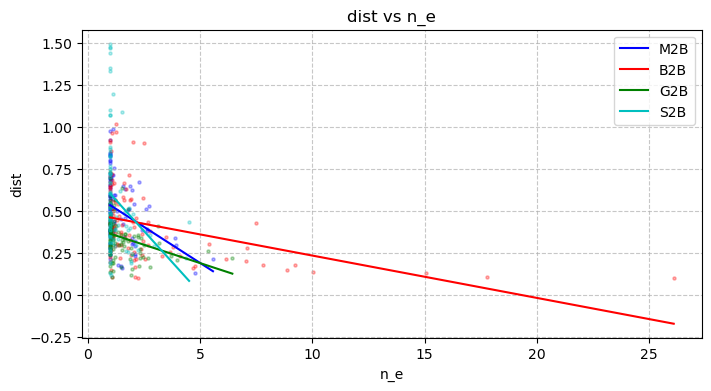

In [51]:
test_names = ["M2B", "B2B", "G2B", "S2B"]
x_column = "n_e"
y_column = "dist"
table_name = "results"

z_column = None#"n_traj_points"
focus = None#[11, 50]

plot_database_columns(test_names, x_column, y_column, table_name, z_column=z_column, focus=focus)


Regression Statistics:
--------------------------------------------------

nountill_M2B:
Equation: y = -0.0001x + 0.5478
R² = 0.0336
p-value = 1.2300e-01
Standard Error = 0.0001

nountill_E2B:
Equation: y = -0.0000x + 0.2121
R² = 0.0154
p-value = 2.9955e-01
Standard Error = 0.0000

nountill_B2B:
Equation: y = 0.0001x + 0.3109
R² = 0.0388
p-value = 9.7215e-02
Standard Error = 0.0001

nountill_G2B:
Equation: y = 0.0001x + 0.3012
R² = 0.0251
p-value = 1.8399e-01
Standard Error = 0.0001

nountill_S2B:
Equation: y = 0.0000x + 0.4746
R² = 0.0023
p-value = 6.8747e-01
Standard Error = 0.0001


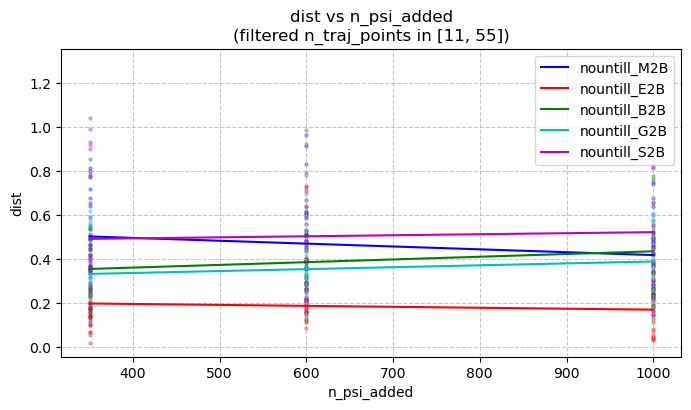


Regression Statistics:
--------------------------------------------------

nountill_M2B:
Equation: y = -0.0000x + 0.4651
R² = 0.0000
p-value = 9.6774e-01
Standard Error = 0.0000

nountill_E2B:
Equation: y = -0.0000x + 0.2062
R² = 0.0113
p-value = 3.7386e-01
Standard Error = 0.0000

nountill_B2B:
Equation: y = -0.0000x + 0.5030
R² = 0.0882
p-value = 1.1321e-02
Standard Error = 0.0000

nountill_G2B:
Equation: y = 0.0000x + 0.3325
R² = 0.0059
p-value = 5.2055e-01
Standard Error = 0.0000

nountill_S2B:
Equation: y = -0.0000x + 0.5528
R² = 0.0066
p-value = 4.9717e-01
Standard Error = 0.0000


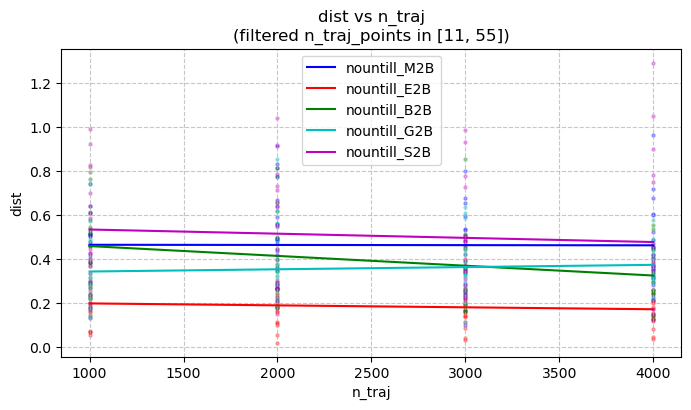


Regression Statistics:
--------------------------------------------------

nountill_M2B:
Equation: y = 0.1571x + 0.3374
R² = 0.0182
p-value = 2.5840e-01
Standard Error = 0.1379

nountill_E2B:
Equation: y = 0.0767x + 0.1228
R² = 0.0181
p-value = 2.5990e-01
Standard Error = 0.0675

nountill_B2B:
Equation: y = -0.1616x + 0.5206
R² = 0.0246
p-value = 1.8800e-01
Standard Error = 0.1216

nountill_G2B:
Equation: y = -0.1683x + 0.4924
R² = 0.0349
p-value = 1.1602e-01
Standard Error = 0.1058

nountill_S2B:
Equation: y = -0.1046x + 0.5890
R² = 0.0043
p-value = 5.8546e-01
Standard Error = 0.1910


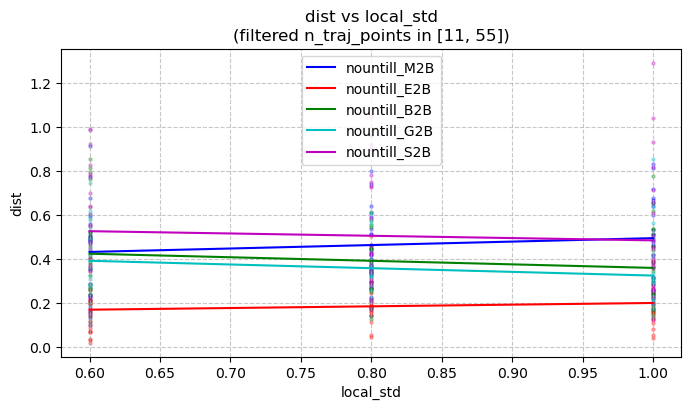


Regression Statistics:
--------------------------------------------------

nountill_M2B:
Equation: y = 0.0001x + 0.4587
R² = 0.0002
p-value = 8.9803e-01
Standard Error = 0.0010

nountill_E2B:
Equation: y = 0.0021x + 0.1137
R² = 0.2542
p-value = 6.3221e-06
Standard Error = 0.0004

nountill_B2B:
Equation: y = 0.0026x + 0.3070
R² = 0.1118
p-value = 4.0936e-03
Standard Error = 0.0009

nountill_G2B:
Equation: y = 0.0019x + 0.2944
R² = 0.0825
p-value = 1.4412e-02
Standard Error = 0.0008

nountill_S2B:
Equation: y = 0.0061x + 0.3049
R² = 0.2609
p-value = 4.5525e-06
Standard Error = 0.0012


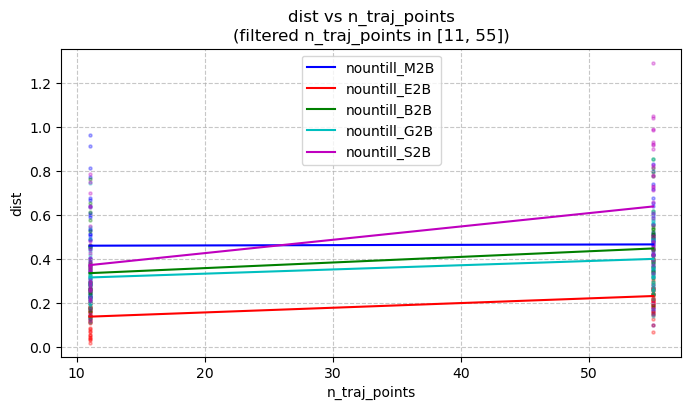

In [60]:
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem']

test_names = ["nountill_M2B", "nountill_E2B", "nountill_B2B", "nountill_G2B", "nountill_S2B"]
#test_names = ["M2B", "E2B", "B2B", "G2B", "S2B"]
y_column = "dist"
table_name = "results"
params = ["n_psi_added", "n_traj", "local_std", "n_traj_points"]

z_column = "n_traj_points"
focus = [11, 55]

for x_column in params:
    plot_database_columns(test_names, x_column, y_column, table_name, z_column=z_column, focus=focus)

[[199.43836912 172.20448052 263.96220181 179.30922666 176.25109748]
 [195.93036361 171.72093371 207.53004741 170.59141009 171.56079142]
 [314.09436685 249.02796489 237.22464734 297.83120828 215.18941604]
 [224.17441042 167.69194556 199.88111386 191.62279976 200.44895164]
 [174.35329544 174.61819372 171.45605631 175.28089392 176.31561572]]


<Figure size 1000x600 with 0 Axes>

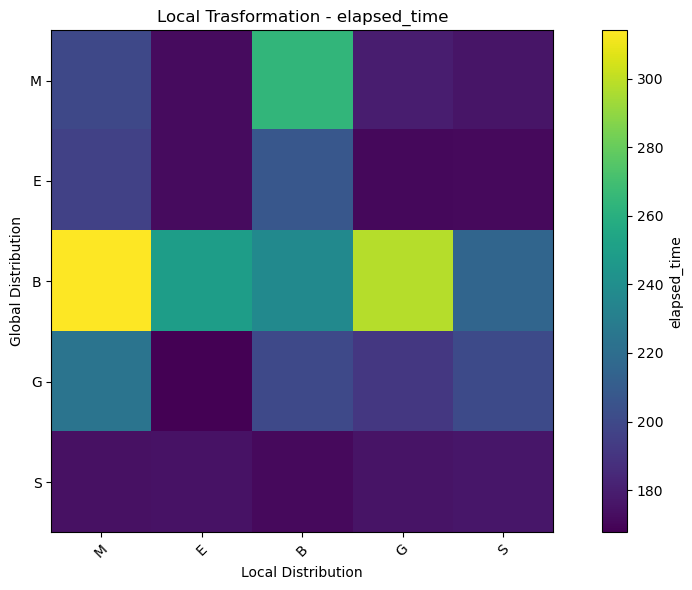

In [66]:
prefix = ""#"nountill_"
tests_acronym = ["M", "E", "B", "G", "S"]
value = "elapsed_time"


plot_tests_vs(tests_acromym=tests_acronym, value=value, prefix=prefix, focus_dict = None, table_name="results")

In [21]:
# Adding the wights variance
#n_e = self.sum_weights**2/self.sum_squared_weights
#['n_psi_added', 'n_traj', 'local_std', 'n_traj_points', 'Dist', 'Cos_Dist', 'Dist_rho', 'Norm_glob', 'Norm_loc', 'Norm_imp', 'Pinv_error', 'Sum_weights', 'Sum_squared_weights', 'Elapsed_time', 'Process_mem']


def add_the_n_e_column(test_name):
    # Create the database path
    database_path = os.path.join("Databases", f"database_{test_name}.db")
    try:
        with sqlite3.connect(database_path) as conn:
            cursor = conn.cursor()
            
            # Check if column exists
            cursor.execute(f"PRAGMA table_info(results)")
            columns = cursor.fetchall()
            column_names = [col[1] for col in columns]
            
            if 'n_e' not in column_names:
                cursor.execute(f"ALTER TABLE results ADD COLUMN n_e REAL")
                print(f"Added 'n_e' column to results")
            
            # Update using a single SQL statement with rowid
            cursor.execute(f"""
                UPDATE results
                SET n_e = (sum_weights * sum_weights) / sum_squared_weights
                WHERE sum_weights IS NOT NULL 
                AND sum_squared_weights IS NOT NULL
                AND sum_squared_weights != 0
            """)
            
            conn.commit()
                
    except sqlite3.Error as e:
        print(f"Database error: {e}")
    except Exception as e:
        print(f"Error: {e}")

In [63]:
for x in ["M", "E", "B", "G", "S"]:
    for y in ["M", "E", "B", "G", "S"]:
        add_the_n_e_column(f"nountill_{x}2{y}")

Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
Added 'n_e' column to results
